In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tablenet import TableNet
from tablenet import image_util

In [2]:
list_ds = tf.data.Dataset.list_files('dataset/Marmot_data/*.xml')

In [3]:
def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.jpg')

  mask_file_path = tf.strings.regex_replace(file_path, '.jpg', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = image_util.normalize(image_util.decode_jpeg(tf.io.read_file(file_path)))
  table_mask = image_util.normalize(image_util.decode_jpeg(tf.io.read_file(table_mask_file_path), channels=1))
  column_mask = image_util.normalize(image_util.decode_jpeg(tf.io.read_file(column_mask_file_path), channels=1))

  return img, {"table_output" : table_mask, "column_output" : column_mask }

In [4]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

(256, 256, 3)


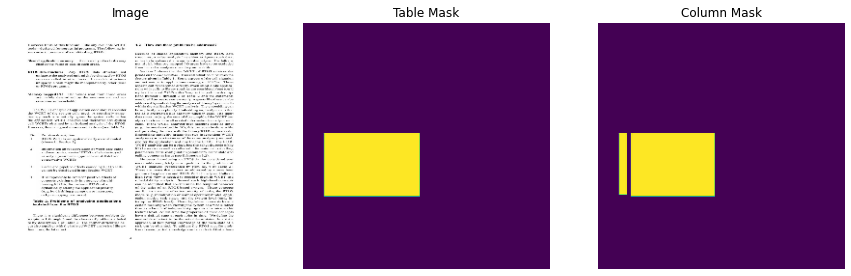

(256, 256, 3)


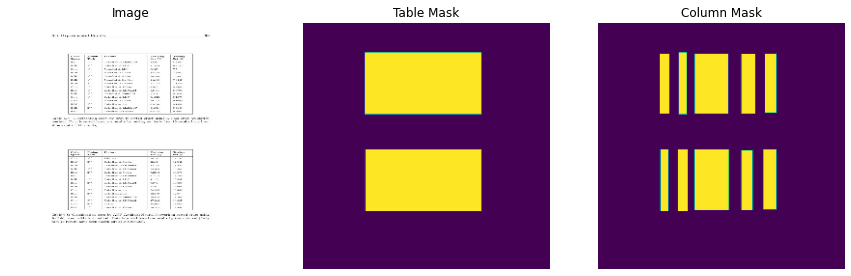

In [5]:
for image, mask  in train.take(2):
  print(image.shape)
  # print(mask.shape)
  image_util.display_image_and_masks(image, mask['table_output'], mask['column_output'])

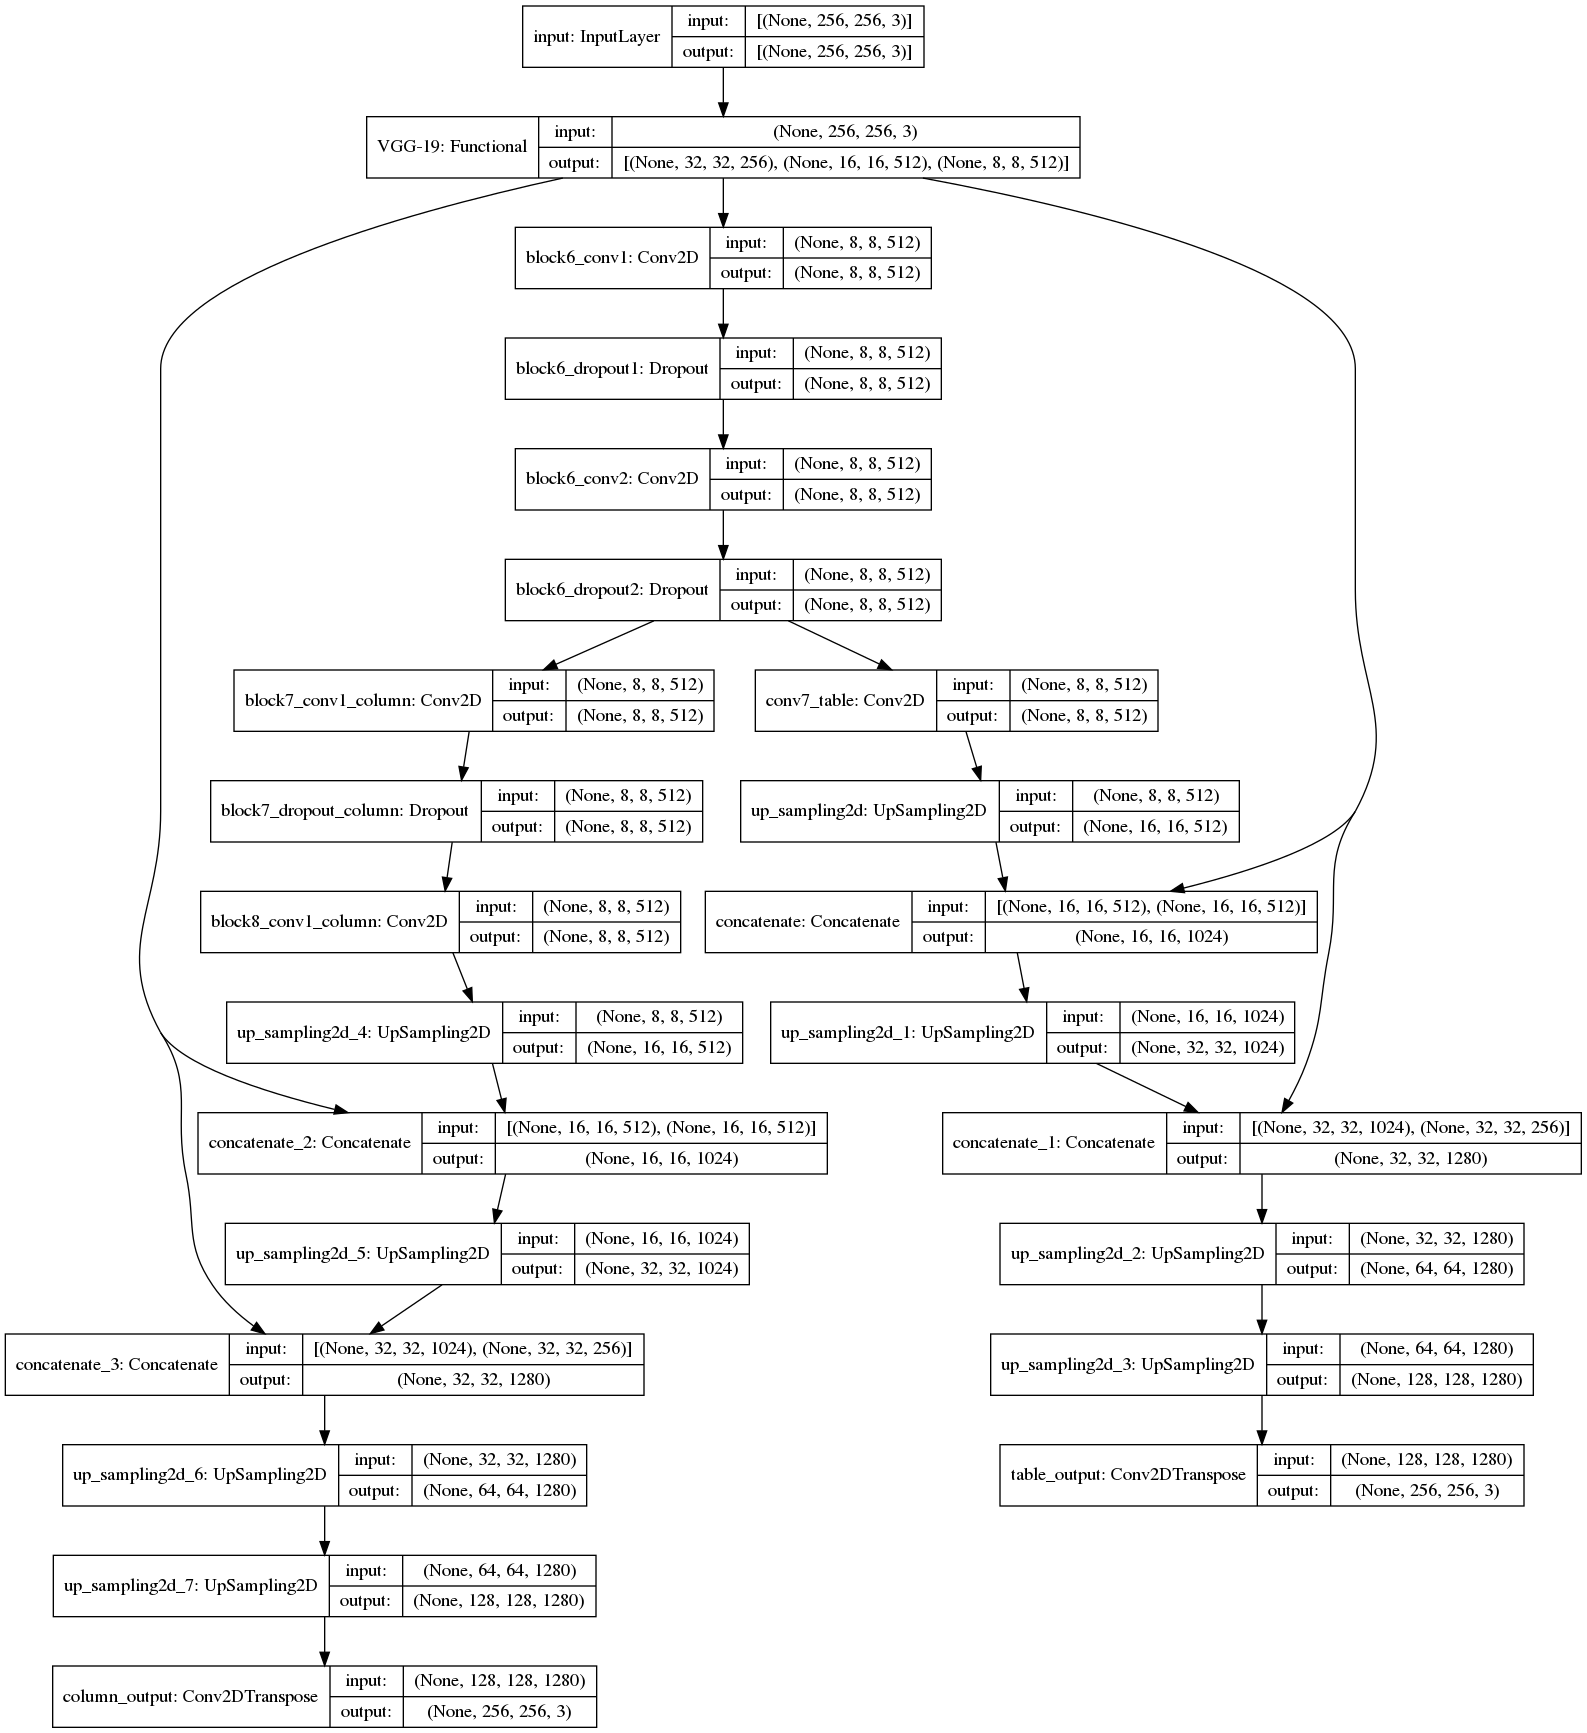

In [6]:
model, table_model, column_model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


In [8]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

print(sample_image.shape)

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      image_util.display_image_and_masks(image[0], table_mask, column_mask)
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    image_util.display_image_and_masks(sample_image[0], table_mask, column_mask)

(2, 256, 256, 3)


1/1 [==============================] - 3s 3s/step


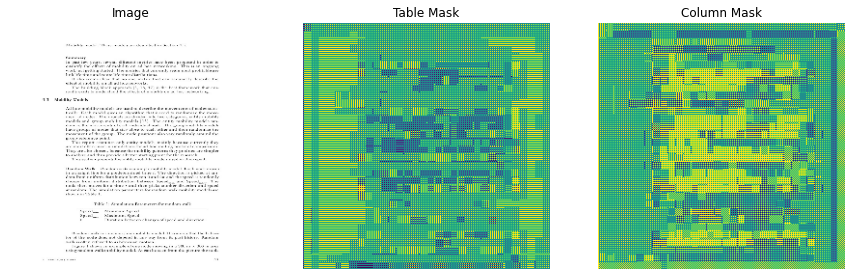

In [9]:
show_predictions()

In [10]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )




Start of epoch 499
Training loss (for one batch): 0.2413
1/1 [==============================] - 0s 80ms/step


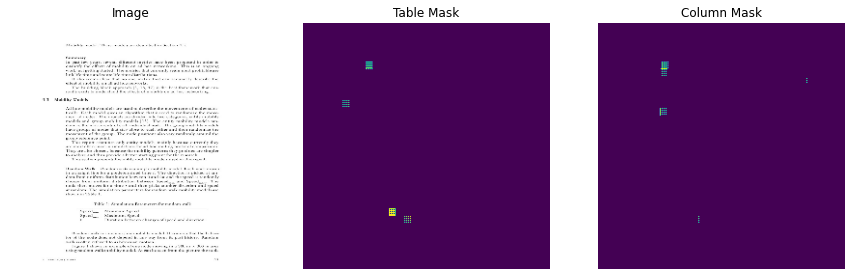

In [13]:
# Custom training loop to train table_output and column_output in a 2:1 ratio
EPOCHS = 500
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
_train_dataset = train.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
loss_value = 100000
for epoch in range(EPOCHS):
    clear_output(wait=True)
    print("\nStart of epoch %d" % (epoch,))
    print("Training loss (for one batch): %.4f" % float(loss_value))
    show_predictions()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(_train_dataset):
        _model = None
        _y_batch_train = None
        if step % 3 == 2:
            _model = column_model
            _y_batch_train = y_batch_train['column_output']
        else:
            _model = table_model
            _y_batch_train = y_batch_train['table_output']

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = _model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(_y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, _model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, _model.trainable_weights))

In [15]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

1/1 [==============================] - 0s 91ms/step


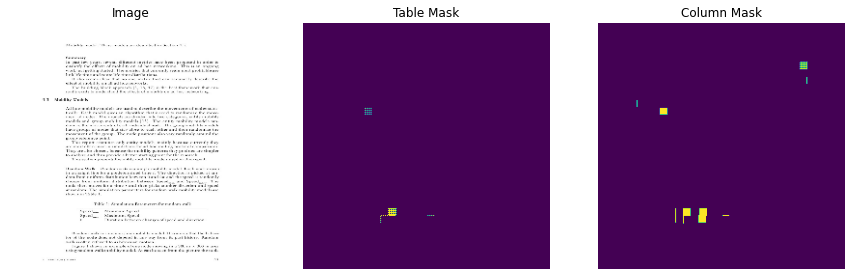


Sample Prediction after epoch 1565


Epoch 01565: val_loss did not improve from 0.11483
Epoch 1566/5000
144/222 [==================>...........] - ETA: 9s - loss: 0.2440 - table_output_loss: 0.1123 - column_output_loss: 0.1317 - table_output_accuracy: 0.9452 - column_output_accuracy: 0.9195

In [ ]:
EPOCHS = 5000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint])

In [ ]:
show_predictions(train_dataset, 5)

In [14]:
model.save('early_500')

INFO:tensorflow:Assets written to: early_500/assets


In [ ]:
!zip -r model66.zip model_66/

In [ ]:
!cp model66.zip '/content/drive/My Drive/Marmot/'